# Experiments on parameters

This notebook can be used to experiment with the different parameters of the models and see how those affect the outcome of the training. The discussion of the results for each hyper-parameter will be divided between the autoencoder and the deep tica models. As the hyper-parameters might affect them differently.

Unlike with alanine dipeptide, here we don't have access to a lower dimensional manifold that separates the metastable states. Thus we cannot simply project the CV onto the $\phi$, $\psi$ space and see how well the model is able to separate the metastable states. Instead, knowing that each trajectory shows a transition between two states, we can project the trajectory on the CV space and see how smoothly it separates the initial and the final states.

In [11]:
from deep_cartograph.run import deep_cartograph
import importlib.resources as resources
from deep_cartograph import data

from IPython.display import display, HTML
from typing import Literal, Dict
from decimal import Decimal
import logging
import shutil
import yaml
import time
import os

# Get the path to the data
data_folder = resources.files(data)

# Set logging level
logging.basicConfig(level=logging.INFO)
    
def run_deep_cartograph(configuration: Dict, features: Literal['torsions', 'distances'], system_name: str, test_name: str):
    """
    Runs deep cartograph using one of the system trajectories. Using one of the feature dictionaries
    and the provided configuration.

    Input
    -----

        configuration: configuration for all the steps of the deep cartograph main workflow
        features:      choice of features to use to train/compute the CVs
        system_name:   name of the system to use
        test_name:     name of the test that will be used as output folder name
    """
    # Input trajectory and topology
    input_path = f"{data_folder}/calpha_transitions/input/{system_name}"
    traj_path = os.path.join(input_path, f'{system_name}.dcd')
    top_path = os.path.join(input_path, f'{system_name}.pdb')
        
    # Output folder
    output_folder = f"{data_folder}/calpha_transitions/experiments/output/{system_name}/{features}/{test_name}"

    # Clean output folder
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)

    # Run workflow 
    deep_cartograph(
        configuration = configuration,
        trajectory_data = traj_path,
        topology_data = top_path,
        output_folder = output_folder)

def show_results(features: Literal['torsions', 'distances'], system_name: str, model_name: str, test_name: str):
    """
    Show the results for a specific model trained with deep cartograph

    Inputs
    ------

        features:    choice of features to use to train/compute the CVs
        system_name: name of the system
        model_name:  name of the model
        test_name:   name of the test to show results for
    """
    def show_score(score_path):
        """
        Print score path in a nice format 

        Input
        -----

            score_path: path to the score file
        """

        # Read score
        with open(score_path, 'r') as file:
            score = file.read()

        # Print score in scientific notation
        print(f"Final model score: {Decimal(score):.4E}")

    def show_eigenvalues(eig_path):
        """
        Print eigenvalues in a nice format

        Input
        -----

            eig_path: path to the eigenvalues file
        """

        # Read eigenvalues
        with open(eig_path, 'r') as file:
            eigenvalues = file.readlines()

        # Print eigenvalues
        for i, eig in enumerate(eigenvalues):
            print(f"Eigenvalue {i+1}: {Decimal(eig):.4E}")

    # Output folder
    output_folder = f"{data_folder}/calpha_transitions/experiments/output/{system_name}/{features}/{test_name}"

    # Show output folder
    print(f"Output folder: {output_folder}")

    # Find model path
    model_path = os.path.join(output_folder, "train_colvars", model_name)

    # Find score if any
    if model_name in ['ae', 'deep_tica']:
        score_path = os.path.join(model_path, "model_score.txt")
        if os.path.exists(score_path):
            show_score(score_path)
        else:
            print("Score file not found")

    # Find eigenvalues if any
    if model_name == 'deep_tica':
        eig_path = os.path.join(model_path, "eigenvalues.txt")
        if os.path.exists(eig_path):
            show_eigenvalues(eig_path)
        else:
            print("Eigenvalues file not found")

    # Paths to images
    loss = os.path.join(model_path, 'loss.png')
    eigenvalues = os.path.join(model_path, 'eigenvalues.png')
    trajectory = os.path.join(model_path, 'trajectory.png')
    paths = [loss, eigenvalues, trajectory]

    # Generate HTML image tags
    timestamp = int(time.time()) # Add timestamp to avoid caching
    images_html = [f'<img src="{path}?{timestamp}" style="width: 600px; margin-right: 10px;">' for path in paths if os.path.exists(path)]

    # Display images
    display(HTML(''.join(images_html)))

## Batch size

Smaller batch sizes can introduce more noise in the gradient updates, which can help the model scape local or sharp minima and find better solutions. Thus generalize better (see relation between training and validation loss). However, smaller batch sizes can also slow down the training process. In this case we have a small dataset and model, so the recommendation is to use a small batch size.

In [12]:

features = 'torsions'

# Load initial configuration
config_path = f"{data_folder}/calpha_transitions/experiments/{features}_config.yml"

with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)
    
batch_sizes = [16, 32, 64, 128, 256]   # 256 is close to all the samples in the training set (330*0.8 = 264)
system_name = '2olu_A-2olv_A-1'        # Has around 330 frames

for bs in batch_sizes:

    # Test name
    test_name = f"bs_{bs}"

    # Make a copy of the initial configuration
    test_configuration = configuration.copy()

    # Update batch size
    test_configuration['train_colvars']['common']['training']['general']['batch_size'] = bs

    # Run deep cartograph
    run_deep_cartograph(test_configuration, features, system_name, test_name)

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/input/2olu_A-2olv_A-1/2olu_A-2olv_A-1.dcd
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: 

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
# Show results for the Autoencoder

for bs in batch_sizes:

    print(f"Batch size: {bs} ----------------------------------------------- #")

    # Test name
    test_name = f"bs_{bs}"
    
    # Show main results
    show_results(features, system_name, 'ae', test_name)

Batch size: 16 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/bs_16
Final model score: 2.4646E-3


Batch size: 32 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/bs_32
Final model score: 2.3508E-3


Batch size: 64 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/bs_64
Final model score: 2.6794E-3


Batch size: 128 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/bs_128
Final model score: 2.6923E-3


Batch size: 256 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/bs_256
Final model score: 3.1106E-3


- We can see that as the batch size increases, the validation loss takes more epochs to decrease

In [3]:
# Show results for Deep TICA

for bs in batch_sizes:

    print(f"Batch size: {bs} ----------------------------------------------- #")

    # Test name
    test_name = f"bs_{bs}"
    
    # Show main results
    show_results(features, system_name, 'deep_tica', test_name)

Batch size: 16 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/bs_16
Final model score: -1.7073E+0
Eigenvalue 1: 1.0026E+0
Eigenvalue 2: 8.2974E-1


Batch size: 32 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/bs_32
Final model score: -2.1778E+1
Eigenvalue 1: 1.5481E+0
Eigenvalue 2: 3.4162E-1


Batch size: 64 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/bs_64
Final model score: -2.9591E+2
Eigenvalue 1: 3.3461E+0
Eigenvalue 2: -2.1429E+0


Batch size: 128 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/bs_128
Final model score: -1.5931E+0
Eigenvalue 1: 9.4375E-1
Eigenvalue 2: 8.3811E-1


Batch size: 256 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/bs_256
Final model score: -1.5529E+0
Eigenvalue 1: 9.4698E-1
Eigenvalue 2: 8.1001E-1


## Learning rate

It controls the size of the steps that the optimizer takes in the direction of the gradient. If the learning rate is too high, the optimizer might overshoot the minimum and diverge. If the learning rate is too low, the optimizer might take too long to converge.

In [ ]:
features = 'torsions'

# Load initial configuration
config_path = f"{data_folder}/calpha_transitions/experiments/{features}_config.yml"

with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)
    
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
system_name = '2olu_A-2olv_A-1'        # Has around 330 frames

for lr in learning_rates:

    # Test name
    test_name = f"lr_{lr}"

    # Make a copy of the initial configuration
    test_configuration = configuration.copy()

    # Update learning rate
    test_configuration['train_colvars']['common']['training']['optimizer']['kwargs']['lr'] = lr

    # Run deep cartograph
    run_deep_cartograph(test_configuration, features, system_name, test_name)

In [5]:
# Show results for the Autoencoder

for lr in learning_rates:

    print(f"Learning rate: {lr} ----------------------------------------------- #")

    # Test name
    test_name = f"lr_{lr}"
    
    # Show main results
    show_results(features, system_name, 'ae', test_name)

Learning rate: 0.01 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lr_0.01
Final model score: 2.6511E-3


Learning rate: 0.001 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lr_0.001
Final model score: 2.6794E-3


Learning rate: 0.0001 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lr_0.0001
Final model score: 3.1012E-3


Learning rate: 1e-05 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lr_1e-05
Final model score: 6.1975E-3


- Note that a lower loss after training does not necessarily mean a better model (see trajectory unfolding on each CV space).

In [6]:
# Show results for the Deep TICA

for lr in learning_rates:

    print(f"Learning rate: {lr} ----------------------------------------------- #")

    # Test name
    test_name = f"lr_{lr}"
    
    # Show main results
    show_results(features, system_name, 'deep_tica', test_name)

Learning rate: 0.01 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lr_0.01
Final model score: -2.1069E+0
Eigenvalue 1: 1.0234E+0
Eigenvalue 2: 6.7373E-1


Learning rate: 0.001 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lr_0.001
Final model score: -2.9591E+2
Eigenvalue 1: 3.3461E+0
Eigenvalue 2: -2.1429E+0


Learning rate: 0.0001 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lr_0.0001
Final model score: -3.9166E+0
Eigenvalue 1: 1.0518E+0
Eigenvalue 2: 1.7334E-1


Learning rate: 1e-05 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lr_1e-05
Final model score: -2.4631E+0
Eigenvalue 1: 9.3888E-1
Eigenvalue 2: 2.6067E-1


- The Deep TICA model is more robust to the learning rate, and it can be trained with a higher learning rate. For the high learning rate, the model can be trained with a single epoch.

## Dropout

Dropout is a regularization technique that consists in randomly setting a fraction of the input tensor to zero during training. This helps the model to generalize better and avoid overfitting. The dropout rate is the fraction of the input tensor that is set to zero.

In [7]:
features = 'torsions'

# Load initial configuration
config_path = f"{data_folder}/calpha_transitions/experiments/{features}_config.yml"

with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)
    
dropout_rates = [0.05, 0.1, 0.2, 0.3, 0.4]
system_name = '2olu_A-2olv_A-1'        # Has around 330 frames

for dr in dropout_rates:

    # Test name
    test_name = f"dr_{dr}"

    # Make a copy of the initial configuration
    test_configuration = configuration.copy()

    # Update learning rate
    test_configuration['train_colvars']['common']['training']['general']['dropout'] = dr

    # Run deep cartograph
    run_deep_cartograph(test_configuration, features, system_name, test_name)

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/input/2olu_A-2olv_A-1/2olu_A-2olv_A-1.dcd
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: 

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
# Show results for the Autoencoder

for dr in dropout_rates:

    print(f"Dropout rate: {dr} ----------------------------------------------- #")

    # Test name
    test_name = f"dr_{dr}"
    
    # Show main results
    show_results(features, system_name, 'ae', test_name)

Dropout rate: 0.05 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/dr_0.05
Final model score: 2.0905E-3


Dropout rate: 0.1 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/dr_0.1
Final model score: 2.6794E-3


Dropout rate: 0.2 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/dr_0.2
Final model score: 3.0903E-3


Dropout rate: 0.3 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/dr_0.3
Final model score: 3.8535E-3


Dropout rate: 0.4 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/dr_0.4
Final model score: 5.0797E-3


In [9]:
# Show results for the Deep TICA

for dr in dropout_rates:

    print(f"Dropout rate: {dr} ----------------------------------------------- #")

    # Test name
    test_name = f"dr_{dr}"
    
    # Show main results
    show_results(features, system_name, 'deep_tica', test_name)

Dropout rate: 0.05 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/dr_0.05
Final model score: -1.9169E+2
Eigenvalue 1: 3.3323E+0
Eigenvalue 2: -1.2842E+0


Dropout rate: 0.1 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/dr_0.1
Final model score: -2.9591E+2
Eigenvalue 1: 3.3461E+0
Eigenvalue 2: -2.1429E+0


Dropout rate: 0.2 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/dr_0.2
Final model score: -4.0898E+0
Eigenvalue 1: 1.2046E+0
Eigenvalue 2: 6.8576E-1


Dropout rate: 0.3 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/dr_0.3
Final model score: -2.5166E+2
Eigenvalue 1: 3.6097E+0
Eigenvalue 2: -1.6659E+0


Dropout rate: 0.4 ----------------------------------------------- #
Output folder: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/dr_0.4
Final model score: -1.7041E+0
Eigenvalue 1: 9.5536E-1
Eigenvalue 2: 8.8869E-1


## Lag time

Lag time is the number of frames between pairs of input samples. It is used in the TICA and Deep TICA models.

INFO:deep_cartograph:================
INFO:deep_cartograph:Compute features
INFO:deep_cartograph:================
INFO:deep_cartograph:Trajectory file: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/input/2olu_A-2olv_A-1/2olu_A-2olv_A-1.dcd
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/pnavarro/miniforge3/envs/deep_cartograph/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1078: UserWarning: 

[Warning] Normalization: the following features have a range of values < 1e-6: tensor([[1]])


/home/pnavarro/repos/mlcolvar/mlcolvar/core/nn/utils.py:13: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  sp0 = F.softplus(torch.zeros(1), self.beta, self.threshold).item()
INFO:deep_cartograph.tools.train_colvars.cv_calculator:Collective variable weights saved to /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lt_8/train_colvars/deep_tica/weights.ptc
INFO:deep_cartograph.tools.train_colvars.train_colvars_workflow:Projecting colvars file: /home/pnavarro/repos/NostrumBD/CV_learning/deep_cartograph/deep_cartograph/data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lt_8/compute_features/2olu_A-2olv_A-1/colvars.dat
INFO:deep_cartograph.tools.train_colvars.train_co

ValueError: Every data point must be inside of the grid.

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

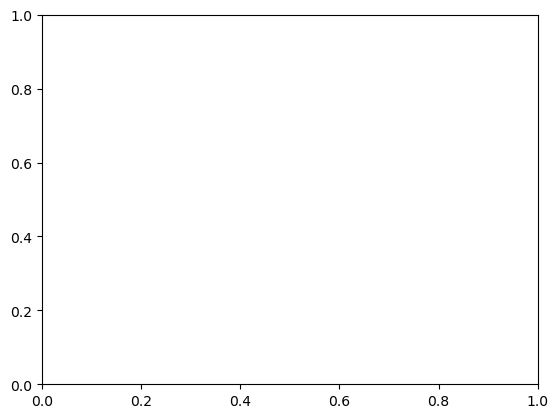

In [10]:
features = 'torsions'

# Load initial configuration
config_path = f"{data_folder}/calpha_transitions/experiments/{features}_config.yml"

with open(config_path, 'r') as file:
    configuration = yaml.load(file, Loader = yaml.FullLoader)
    
lag_times = [1, 2, 4, 8, 16]
system_name = '2olu_A-2olv_A-1'        # Has around 330 frames

for lt in lag_times:

    # Test name
    test_name = f"lt_{lt}"

    # Make a copy of the initial configuration
    test_configuration = configuration.copy()

    # Update learning rate
    test_configuration['train_colvars']['common']['architecture']['lag_time'] = lt

    # Run deep cartograph
    run_deep_cartograph(test_configuration, features, system_name, test_name)

In [20]:
# Show results for Deep TICA

for lt in lag_times:

    print(f"Lag time: {lt} ----------------------------------------------- #")

    # Test name
    test_name = f"lt_{lt}"
    
    # Show main results
    show_results(features, system_name, 'deep_tica', test_name)

Lag time: 1 ----------------------------------------------- #
Output folder: ../../../data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lt_1
Final model score: -1.9195E+0
Eigenvalue 1: 9.8996E-1
Eigenvalue 2: 9.6897E-1


Lag time: 2 ----------------------------------------------- #
Output folder: ../../../data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lt_2
Final model score: -9.5201E+1
Eigenvalue 1: 2.2902E+0
Eigenvalue 2: -2.8179E-1


Lag time: 4 ----------------------------------------------- #
Output folder: ../../../data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lt_4
Final model score: -3.2059E+2
Eigenvalue 1: 3.1755E+0
Eigenvalue 2: -1.3986E+0


Lag time: 8 ----------------------------------------------- #
Output folder: ../../../data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lt_8
Final model score: -1.8162E+0
Eigenvalue 1: 1.0153E+0
Eigenvalue 2: 8.7031E-1


Lag time: 16 ----------------------------------------------- #
Output folder: ../../../data/calpha_transitions/experiments/output/2olu_A-2olv_A-1/torsions/lt_16
Final model score: -1.8405E+0
Eigenvalue 1: 1.0926E+0
Eigenvalue 2: 8.0412E-1


- Lag time should be 1